<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/83tnWs_YBRQ

**This notebook walks you through the process of fine-tuning a Segment Anything Model (SAM) using custom data**.
<p>

**What is SAM?**
<br>
SAM is an image segmentation model developed by Meta AI. It was trained over 11 billion segmentation masks from millions of images. It is designed to take human prompts, in the form of points, bounding boxes or even a text prompt describing what should be segmented.
<p>

**What are the key features of SAM?**
<br>

* **Zero-shot generalization:** SAM can be used to segment objects that it has never seen before, without the need for additional training.

* **Flexible prompting:** SAM can be prompted with a variety of input, including points, boxes, and text descriptions.

* **Real-time mask computation:** SAM can generate masks for objects in real time. This makes SAM ideal for applications where it is necessary to segment objects quickly, such as autonomous driving and robotics.

* **Ambiguity awareness:** SAM is aware of the ambiguity of objects in images. This means that SAM can generate masks for objects even when they are partially occluded or overlapping with other objects.

<p>

**How does SAM work?**
<br>
SAM works by first encoding the image into a high-dimensional vector representation. The prompt is encoded into a separate vector representation. The two vector representations are then combined and passed to a mask decoder, which outputs a mask for the object specified by the prompt.
<p>
The image encoder is a vision transformer (ViT-H) model, which is a large language model that has been pre-trained on a massive dataset of images. The prompt encoder is a simple text encoder that converts the input prompt into a vector representation. The mask decoder is a lightweight transformer model that predicts the object mask from the image and prompt embeddings.
<p>

**SAM paper:** https://arxiv.org/pdf/2304.02643.pdf​
<p>

**Link to the dataset used in this demonstration:** https://www.epfl.ch/labs/cvlab/data/data-em/
<br>Courtesy: EPFL
<p>

This code has been heavily adapted from this notebook but modified to work with a truly custom dataset where we have a bunch of images and binary masks.
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb



In [15]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

^C
Traceback (most recent call last):
  File "/home/jpan/miniconda3/bin/pip", line 7, in <module>
    from pip._internal.cli.main import main
  File "/home/jpan/miniconda3/lib/python3.12/site-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/home/jpan/miniconda3/lib/python3.12/site-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/home/jpan/miniconda3/lib/python3.12/site-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/home/jpan/miniconda3/lib/python3.12/site-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spinners import open_spinner
  File "/home/jpan/miniconda3/lib/python3.12/site-packages/pip/_internal/cli/spinners.py", line 9, in <module>
    from pip._internal.utils.logging import get_indentatio

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage 
from pycocotools import mask as maskUtils
import yaml

In [2]:
import torch
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from segment_anything import SamPredictor, sam_model_registry
import torchvision.transforms.functional as F

# Load the COCO dataset
train_dataset = CocoDetection(
    root="/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/train",
    annFile="/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/train/_annotations.coco.json",
    transform = ToTensor()
)

val_dataset = CocoDetection(
    root="/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/valid",
    annFile="/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/valid/_annotations.coco.json",
    transform=ToTensor()
)

test_dataset = CocoDetection(
    root="/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/test",
    annFile="/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/test/_annotations.coco.json",
    transform=ToTensor()
)

batch_size = 1

# Load the data into a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/home/jpan/miniconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Image shape: torch.Size([3, 1024, 1024])
Number of targets: 1
Annotations: [{'id': tensor([0]), 'image_id': tensor([0]), 'category_id': tensor([1]), 'bbox': [tensor([259]), tensor([0]), tensor([461.3330], dtype=torch.float64), tensor([1024])], 'area': tensor([472405.3330], dtype=torch.float64), 'segmentation': [[tensor([270.6670], dtype=torch.float64), tensor([0]), tensor([269.3330], dtype=torch.float64), tensor([1]), tensor([269.3330], dtype=torch.float64), tensor([7]), tensor([266.6670], dtype=torch.float64), tensor([9]), tensor([266.6670], dtype=torch.float64), tensor([83]), tensor([269.3330], dtype=torch.float64), tensor([85]), tensor([269.3330], dtype=torch.float64), tensor([95]), tensor([266.6670], dtype=torch.float64), tensor([97]), tensor([266.6670], dtype=torch.float64), tensor([99]), tensor([269.3330], dtype=torch.float64), tensor([101]), tensor([269.3330], dtype=torch.float64), tensor([207]), tensor([266.6670], dtype=torch.float64), tensor([209]), tensor([266.6670], dtype=to

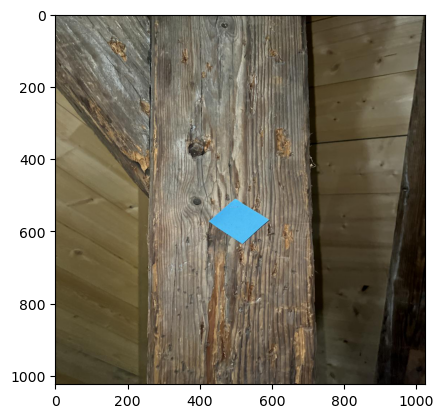

In [ ]:
# Process the images
for images, targets in train_loader:
    # Since batch_size=1, we need to access images[0] and targets[0]
    image = images[0]
    target = targets[0]

    print(f"Image shape: {image.shape}")
    print(f"Number of targets: {len(targets)}")
    print(f"Annotations: {targets}")

    # Display the image
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.show()

    break  # Only display the first item


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Function to display an image along with its annotations
def display_image(image, annotation):
    print(f"Image shape: {image.shape}")
    plt.imshow(image.permute(1, 2, 0).numpy())
    
    height, width = image.shape[1], image.shape[2]
    
    if isinstance(annotation, list):
        for ann in annotation:
            if isinstance(ann['segmentation'], list):
                mask = np.zeros((height, width), dtype=np.uint8)
                for seg in ann['segmentation']:
                    # Convert tensor to numpy array and reshape
                    poly = np.array(seg).reshape((-1, 2))
                    poly = poly.astype(np.int32)  # Convert to int32 for cv2.fillPoly
                    cv2.fillPoly(mask, [poly], 1)
            else:
                mask = F.pil_to_tensor(ann['segmentation']).squeeze().numpy()

            print(f"Mask shape: {mask.shape}")
            plt.imshow(mask, alpha=0.5)
    else:
        print("Annotation is not in expected format.")
    
    plt.show()

# Load one batch of data
for images, annotations in train_loader:
    image = images[0]
    annotation = annotations[0]
    print(f"Annotations: {annotation}")  # Print the annotation to check its format
    display_image(image, annotation)
    break


In [6]:
checkpoint_path = "sam_vit_b_01ec64.pth"
assert os.path.isfile(checkpoint_path), f"File {checkpoint_path} does not exist or is not a file."
sam = sam_model_registry["vit_b"](checkpoint=checkpoint_path)
predictor = SamPredictor(sam)

project_name = "SAM"
task_name = "SAM_02_0609"

output_dir = rf"/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/SAM/202406_SegmentAnything/{task_name}"
os.makedirs(output_dir, exist_ok=True)

num_classes = 3  
num_epochs = 3
lr = 1e-4

# Save training configuration to YAML file
config = {
    'project_name': project_name,
    'task_name': task_name,
    'num_classes': num_classes,
    'num_epochs': num_epochs,
    'learning_rate': lr,
    'batch_size': batch_size,
    'checkpoint_path': checkpoint_path,
}


config_path = os.path.join(output_dir, 'config.yaml')
with open(config_path, 'w') as file:
    yaml.dump(config, file)

sam.train()

# Ensure all parameters require gradients
for param in sam.parameters():
    param.requires_grad = True

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sam.parameters(), lr=lr)

def get_bounding_box(target):
    bbox = target['bbox']
    bbox = [float(val) for val in bbox]
    bbox = np.array(bbox).reshape(1, 4)
    return bbox

def get_segmentation_mask(target, image_size):
    segmentation = target['segmentation']
    
    # Ensure segmentation is a list of lists of tensors
    if not isinstance(segmentation, list) or not all(isinstance(poly, list) for poly in segmentation):
        raise ValueError(f"Invalid segmentation format: {segmentation}")

    # Convert tensors to lists
    segmentation = [[float(coord) for coord in poly] for poly in segmentation]

    rle = maskUtils.frPyObjects(segmentation, image_size[0], image_size[1])
    mask = maskUtils.decode(rle)
    if len(mask.shape) == 3:
        mask = np.any(mask, axis=2).astype(np.uint8)
    return torch.tensor(mask, dtype=torch.long)

def get_image_info(dataset, index):
    """Get image info such as file name"""
    image_id = dataset.ids[index]
    img_info = dataset.coco.loadImgs(image_id)[0]
    return img_info['file_name']

def get_annotation_info(dataset, target):
    """Get annotation info such as annotation id or name"""
    ann_id = target['id']
    return f"Annotation ID: {ann_id}"



In [7]:
#clearml mac
# %env CLEARML_WEB_HOST=https://app.clear.ml
# %env CLEARML_API_HOST=https://api.clear.ml
# %env CLEARML_FILES_HOST=https://files.clear.ml
# %env CLEARML_API_ACCESS_KEY=QO1VBBX9J2S2VYILQTGI
# %env CLEARML_API_SECRET_KEY=ERuc1S6o5SirQGugvYXDFjH9b9aNi0u8S3rpALzXMa8YPSLDMW

# clearml win
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=Z4YDBU13VPOFHBHF8667
%env CLEARML_API_SECRET_KEY=JMzvRXn76AT83WuFJfS0FBGCY8c5TccbH5XboTYztrWqwzDdyn

from clearml import Task

#Clear ML Initialization
cl_task = Task.init(project_name=project_name,task_name=task_name)
logger = cl_task.get_logger()

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=Z4YDBU13VPOFHBHF8667
env: CLEARML_API_SECRET_KEY=JMzvRXn76AT83WuFJfS0FBGCY8c5TccbH5XboTYztrWqwzDdyn
ClearML Task: created new task id=deafa1989dc8453ab58303fd17347367
ClearML results page: https://app.clear.ml/projects/3230392d1db54f0d87f52243e729d3b8/experiments/deafa1989dc8453ab58303fd17347367/output/log


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [8]:
for epoch in range(num_epochs):
    sam.train()
    train_loss = 0
    for batch_idx, (images, targets) in enumerate(train_loader):
        image = images[0].requires_grad_()
        image = F.to_pil_image(image)
        image = np.array(image)

        # Print the image name at the start of each batch
        image_name = get_image_info(train_dataset, batch_idx)
        print(f"Processing image: {image_name}")

        for target in targets:  # Loop over all targets in the current image
            bboxes = get_bounding_box(target)

            for bbox in bboxes:
                x_min, y_min, width, height = bbox
                x_max = x_min + width
                y_max = y_min + height
                input_bbox = np.array([x_min, y_min, x_max, y_max])

                predictor.set_image(image)
                masks, _, _ = predictor.predict(box=input_bbox, point_coords=None, point_labels=None, multimask_output=False)

                # Convert masks to tensor and ensure it's a float tensor
                masks = torch.tensor(masks, dtype=torch.float32).squeeze(0)

                # Create num_classes channels for masks
                masks = torch.nn.functional.one_hot(masks.to(torch.int64), num_classes=num_classes).permute(2, 0, 1).float()
                masks.requires_grad_()  # Ensure masks require grad
                target_mask = get_segmentation_mask(target, image.shape[:2])

                # Ensure masks and target_mask are the same shape
                if masks.shape[1:] != target_mask.shape:
                    masks = F.resize(masks, target_mask.shape)

                # Print annotation info and shapes inside the loop
                annotation_info = get_annotation_info(train_dataset, target)
                print(f"train {annotation_info}, masks shape: {masks.shape}, dtype: {masks.dtype}")
                print(f"train target_mask shape: {target_mask.shape}, dtype: {target_mask.dtype}")

                # Expand target_mask to match masks shape for criterion
                target_mask = target_mask.unsqueeze(0)

                loss = criterion(masks.unsqueeze(0), target_mask)

                # Backpropagation and optimizing
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Validation
    sam.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_loader):
            image = images[0]
            image = F.to_pil_image(image)
            image = np.array(image)

            # Print the image name at the start of each batch
            image_name = get_image_info(val_dataset, batch_idx)
            print(f"Processing image: {image_name}")

            for target in targets:  # Loop over all targets in the current image
                bboxes = get_bounding_box(target)

                for bbox in bboxes:
                    x_min, y_min, width, height = bbox
                    x_max = x_min + width
                    y_max = y_min + height
                    input_bbox = np.array([x_min, y_min, x_max, y_max])

                    predictor.set_image(image)
                    masks, _, _ = predictor.predict(box=input_bbox, point_coords=None, point_labels=None, multimask_output=False)

                    # Convert masks to tensor and ensure it's a float tensor
                    masks = torch.tensor(masks, dtype=torch.float32).squeeze(0)

                    # Create num_classes channels for masks
                    masks = torch.nn.functional.one_hot(masks.to(torch.int64), num_classes=num_classes).permute(2, 0, 1).float()
                    target_mask = get_segmentation_mask(target, image.shape[:2])

                    # Ensure masks and target_mask are the same shape
                    if masks.shape[1:] != target_mask.shape:
                        masks = F.resize(masks, target_mask.shape)

                    # Print annotation info and shapes inside the loop
                    annotation_info = get_annotation_info(val_dataset, target)
                    print(f"val {annotation_info}, masks shape: {masks.shape}, dtype: {masks.dtype}")
                    print(f"val target_mask shape: {target_mask.shape}, dtype: {target_mask.dtype}")

                    # Expand target_mask to match masks shape for criterion
                    target_mask = target_mask.unsqueeze(0)

                    loss = criterion(masks.unsqueeze(0), target_mask)
                    val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}")

print("Finished Fine-tuning")

# Save the model
model_save_path = os.path.join(output_dir, f"{task_name}.pth")
torch.save(sam.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

cl_task.close()

Processing image: Model_9_0022_jpeg.rf.5c17170c27b51fe5d05f67a625f991ee.jpg
train Annotation ID: tensor([0]), masks shape: torch.Size([3, 1024, 1024]), dtype: torch.float32
train target_mask shape: torch.Size([1024, 1024]), dtype: torch.int64
Processing image: Model_16_0018_jpeg.rf.5c6db7932a5238ce22ea096f30c53399.jpg
train Annotation ID: tensor([1]), masks shape: torch.Size([3, 1024, 1024]), dtype: torch.float32
train target_mask shape: torch.Size([1024, 1024]), dtype: torch.int64
Processing image: Model_18_0017_jpeg.rf.5ef2ea61331f40e29ee6ec31937edf4f.jpg
train Annotation ID: tensor([2]), masks shape: torch.Size([3, 1024, 1024]), dtype: torch.float32
train target_mask shape: torch.Size([1024, 1024]), dtype: torch.int64
train Annotation ID: tensor([3]), masks shape: torch.Size([3, 1024, 1024]), dtype: torch.float32
train target_mask shape: torch.Size([1024, 1024]), dtype: torch.int64
train Annotation ID: tensor([4]), masks shape: torch.Size([3, 1024, 1024]), dtype: torch.float32
train

Load data into numpy arrays. Here we are importing a tiff stack containing 165 images of size 768x1024. You can use glob to import multiple images from a directory or any other method. The goal is to end up with a numpy array for images and an array for masks.

In [ ]:
# Load tiff stack images and masks

#165 large images as tiff image stack
large_images = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/data/mitochondria/full_dataset/images/mitochondria_train_01.tif")
large_masks = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/data/mitochondria/full_dataset/masks/mitochondria_train_masks_01.tif")


In [ ]:
large_images.shape

Now. let us divide these large images into smaller patches for training. We can use patchify or write custom code.

In [ ]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [ ]:
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [ ]:
images.shape

Now, let us delete empty masks as they may cause issues later on during training. If a batch contains empty masks then the loss function will throw an error as it may not know how to handle empty tensors.

In [ ]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Let us create a 'dataset' that serves us input images and masks for the rest of our journey.

In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [ ]:
dataset

Let us make sure out images and masks (labels) are loading appropriately

In [ ]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


In [ ]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

In [ ]:
batch["ground_truth_mask"].shape

In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/models/SAM/mito_model_checkpoint.pth")

**Inference**

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/models/SAM/mito_full_data_10_epochs_model_checkpoint.pth"))

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


Now, let us load a new image and segment it using our trained model. NOte that we need to provide some prompt. Since we do not know where the objects are going to be we cannot supply bounding boxes. So let us provide a grid of points as our prompt.

In [ ]:
#Apply a trained model on large image
large_test_images = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/data/mitochondria/small_dataset_for_training/images/12_training_mito_images.tif")
large_test_image = large_test_images[1]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap


In [ ]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [ ]:
print(np.array(input_points).shape)

In [ ]:
patches.shape

In [ ]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2

# Selectelected patch for segmentation
random_array = patches[i, j]


single_patch = Image.fromarray(random_array)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()